# AQI

In [2]:
%load_ext autotime

time: 258 µs (started: 2023-03-15 19:03:38 +05:30)


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

import numpy as np
import pandas as pd
import random
from glob import glob
import os, shutil
import gc
from PIL import Image
from typing import Dict, List, Tuple, Any, Optional
from collections import namedtuple, defaultdict
import copy

import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, StratifiedKFold, StratifiedGroupKFold

import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import piqa
import wandb
from tqdm import tqdm
tqdm.pandas()

from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

time: 4.07 s (started: 2023-03-15 19:03:38 +05:30)


## Config

In [4]:
class config:
    seed          = 42
    exp_name      = 'nasscom-taim'
    model_name    = 'pix2pix-rnn-aqi'
    base_model    = 'None'
    train_bs      = 1
    valid_bs      = 1
    image_size    = [224, 224]
    in_channels   = 1
    latent_size   = 128
    hidden_size   = 512
    num_layers    = 2
    bidirectional = 0 # could be 0 or 1
    comment       = f'model-{model_name}|latent_size-{latent_size}|info_channels-{in_channels}|hidden_dim-{hidden_size}|num_layers-{num_layers}|bidirectional-{bidirectional}|dim-{image_size[0]}x{image_size[1]}'
    epochs        = 100
    learning_rate = 3e-4
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    num_classes   = 3
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    trial_num     = 1

time: 1.16 ms (started: 2023-03-15 19:03:42 +05:30)


## Utils

In [5]:
def set_seed(seed: int = 42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('>>> SEEDED <<<')

set_seed(config.seed)

>>> SEEDED <<<
time: 2.1 ms (started: 2023-03-15 19:03:42 +05:30)


In [6]:
class Conv2DLayer(nn.Module):
    def __init__(
        self,
        in_channels: int, 
        out_channels: int, 
        kernel_size: int, 
        stride: int, 
        padding: int
    ) -> None:
        super(Conv2DLayer, self).__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels, 
            kernel_size=kernel_size, 
            stride=stride, 
            padding=padding
        )
        self.bn = nn.BatchNorm2d(num_features=out_channels)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.relu(self.bn(self.conv(x)))

time: 682 µs (started: 2023-03-15 19:03:42 +05:30)


In [7]:
class Conv2DTransposeLayer(nn.Module):
    def __init__(
        self,
        in_channels: int, 
        out_channels: int, 
        kernel_size: int, 
        stride: int, 
        padding: int 
    ) -> None:
        super(Conv2DTransposeLayer, self).__init__()
        self.conv = nn.ConvTranspose2d(
            in_channels=in_channels, 
            out_channels=out_channels, 
            kernel_size=kernel_size, 
            stride=stride, 
            padding=padding
        )
        self.bn = nn.BatchNorm2d(num_features=out_channels)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.relu(self.bn(self.conv(x)))

time: 823 µs (started: 2023-03-15 19:03:42 +05:30)


In [8]:
def get_optimizer(optimizer: optim):
    if config.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(
            optimizer=optimizer, 
            T_max=config.T_max, 
            eta_min=config.min_lr
        )
    elif config.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer=optimizer, 
            T_0=config.T_0, 
            eta_min=config.eta_min
        )
    elif config.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer, 
            mode='min',
            factor=0.1, 
            patience=10, 
            threshold=0.0001, 
            min_lr=config.min_lr
        )
    elif config.scheduler == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(
            optimizer=optimizer, 
            gamma=0.85
        )
    elif config.scheduler == None:
        scheduler = None
    else:
        raise NotImplementedError("The Scheduler you have asked has not been implemented")
    return scheduler

time: 1.04 ms (started: 2023-03-15 19:03:42 +05:30)


## Model

## Encoder

In [9]:
class EncoderLayer(nn.Module):
    def __init__(
            self, 
            in_channels: int,
            latent_size: int, 
            *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        self.conv1 = Conv2DLayer(in_channels=in_channels, out_channels=32, kernel_size=8, stride=4, padding=1)
        self.conv2 = Conv2DLayer(in_channels=32, out_channels=16, kernel_size=2, stride=4, padding=1)
        self.conv3 = Conv2DLayer(in_channels=16, out_channels=1, kernel_size=2, stride=1, padding=1)
        self.fc    = nn.Linear(in_features=225, out_features=latent_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.size(0)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(batch_size, -1)
        x = self.fc(x)
        return x

time: 720 µs (started: 2023-03-15 19:03:42 +05:30)


### Decoder

In [10]:
class DecoderLayer(nn.Module):
    def __init__(
        self, 
        latent_size: int,
        out_channels: int,
        *args, **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        
        self.conv1 = Conv2DTransposeLayer(in_channels=latent_size, out_channels=128, kernel_size=6, 
                                          stride=3, padding=1)
        self.conv2 = Conv2DTransposeLayer(in_channels=128, out_channels=64, kernel_size=4, stride=4, padding=1)
        self.conv3 = Conv2DTransposeLayer(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.conv4 = Conv2DTransposeLayer(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1)
        self.conv5 = Conv2DTransposeLayer(in_channels=16, out_channels=8, kernel_size=4, stride=2, padding=1)
        self.conv6 = Conv2DTransposeLayer(in_channels=8, out_channels=out_channels, kernel_size=4, stride=2, padding=1)
#         self.conv7 = Conv2DTransposeLayer(in_channels=4, out_channels=3, kernel_size=4, stride=2, padding=1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        return x

time: 951 µs (started: 2023-03-15 19:03:42 +05:30)


### Pix2PixRNN

In [11]:
class Pix2PixRNN(nn.Module):
    def __init__(
            self, 
            in_channels: int = 3, 
            latent_size: int = 128,
            hidden_size: int = 512,
            num_layers: int = 2,
            bidirectional: Optional[int] = 1,
            *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.in_channels = in_channels
        self.latent_size = latent_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        self.encoder = EncoderLayer(in_channels=in_channels, latent_size=latent_size)
        self.lstm = nn.LSTM(
            input_size=latent_size,
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True,
            bidirectional=True if self.bidirectional == 2 else False
        )
        self.decoder = DecoderLayer(latent_size=self.hidden_size, out_channels=self.in_channels)

    def _init_hidden_states(self, bs: int) -> Tuple[torch.Tensor]:
        return torch.zeros(self.bidirectional*self.num_layers, bs, self.hidden_size), \
    torch.zeros(self.bidirectional*self.num_layers, bs, self.hidden_size)
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor]:
        emb = None
        seq_len = x.size(2) # [B, C, D, H, W]
        for ix in range(seq_len):
            if emb is None:
                emb = self.encoder(x[:, :, ix, :, :]).unsqueeze(0)
            else:
                emb = torch.cat([emb, self.encoder(x[:, :, ix, :, :]).unsqueeze(0)], dim=0)
        # emb = self.encoder(x)
        emb = emb.permute(1, 0, 2)
        
        # h0, c0 = self._init_hidden_states(64)
        out, (h, c) = self.lstm(emb)
        
        decoder_inp = torch.cat([h, c])
        decoder_inp = torch.mean(decoder_inp, axis=0).unsqueeze(-1).unsqueeze(-1)
        out = self.decoder(decoder_inp)
        return nn.Sigmoid()(out)


x = torch.randn((64, 1, 8, 224, 224))
model = Pix2PixRNN(in_channels=1, latent_size=128, bidirectional=2)
decoder_inp = model.forward(x)
decoder_inp.shape

torch.Size([64, 1, 224, 224])

time: 1.32 s (started: 2023-03-15 19:03:42 +05:30)


## Training

In [12]:
def get_prediction_plots(y: torch.Tensor, yHat: torch.Tensor):
    img_id = np.random.choice(range(len(y)))
    fig, axs = plt.subplots(2, 4, figsize=(12, 12))
    axs[0][0].set_ylabel('Actual')
    axs[1][0].set_ylabel('Predicted')
    for ix, ax in enumerate(axs[1].flatten()):
        ax.imshow(y[ix][0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    
    for ix, ax in enumerate(axs[1].flatten()):
        ax.imshow(yHat[ix][0].detach().numpy(), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    
#     plt.tight_layout()
#     plt.imsave(fig, './preds.png')
    plt.savefig('./preds.png')

time: 579 µs (started: 2023-03-15 19:03:44 +05:30)


In [13]:
def train_one_epoch(
    model: nn.Module, optimizer: optim, scheduler: lr_scheduler, 
    criterion: nn.Module, loader: DataLoader
) -> float:
    model.train()
    running_loss = 0.0
    dataset_size = 0
    
    ssim_loss = piqa.SSIM(n_channels=1)
    psnr_loss = piqa.PSNR()
    
    pbar = tqdm(enumerate(loader), total=len(loader), desc='Train')
    for step, batch in pbar:
        X, y, mask = batch['X'], batch['y'], batch['mask']
        bs = X.shape[0]
        yHat = model.forward(X)
        
        optimizer.zero_grad()
        loss = criterion(yHat*mask, y*mask)# , mask)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        running_loss += (loss.item() * bs)
        dataset_size += bs
        
        with torch.no_grad():
            ssim = ssim_loss(yHat*mask, y*mask)
            psnr = psnr_loss(yHat*mask, y*mask)
        
        epoch_loss = running_loss / dataset_size
        current_lr = optimizer.param_groups[0]['lr']
        
        wandb.log({
            'running train loss': epoch_loss,
            'running learning rate': current_lr,
            'training ssim': ssim,
            'training psnr': psnr
        })
    
        pbar.set_postfix(loss=f'{epoch_loss:.3f}', lr=f'{current_lr:.5f}')
    
    return epoch_loss


@torch.no_grad()
def validate_one_epoch(model: nn.Module, loader: DataLoader, criterion: nn.Module) -> float:
    model.eval()
    running_loss = 0.0
    dataset_size = 0
    
    ssim_loss = piqa.SSIM(n_channels=1)
    psnr_loss = piqa.PSNR()
    
    pbar = tqdm(enumerate(loader), total=len(loader), desc='Evaluation')
    for step, batch in pbar:
        X, y, mask = batch['X'], batch['y'], batch['mask']
        bs = X.shape[0]
        yHat = model.forward(X)
        
        y *= mask
        yHat *= mask
        loss = criterion(yHat, y)# , mask)
        
        running_loss += (bs * loss.item())
        dataset_size += bs
        epoch_loss = running_loss / dataset_size
        
        epoch_loss = running_loss / dataset_size
        
#         get_prediction_plots(y=y, yHat=yHat)

        wandb.log({
            'running valid loss': epoch_loss,
            'predictions': wandb.Image('./preds.png'),
            'validation ssim': ssim_loss(yHat, y),
            'validation psnr': psnr_loss(yHat, y)
        })
    
    return epoch_loss

time: 1.53 ms (started: 2023-03-15 19:03:44 +05:30)


In [14]:
class CustomMSELoss(nn.Module):
    def __init__(self) -> None:
        super(CustomMSELoss, self).__init__()
    
    def forward(self, yHat: torch.Tensor, y: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        return torch.sum((yHat*mask-y*mask)**2)

time: 358 µs (started: 2023-03-15 19:03:44 +05:30)


In [15]:
def run_training(trainloader, validloader):
    wandb.init(
        project='nasscom-taim',
        config={k:v for k, v in vars(config).items() if '__' not in k},
        name=f'iteration-{config.trial_num}',
        group=config.comment
    )
    
    model = Pix2PixRNN(
        in_channels=config.in_channels, 
        latent_size=config.latent_size,
        hidden_size=config.hidden_size, 
        num_layers=config.num_layers
    ).to(config.device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    scheduler = get_optimizer(optimizer=optimizer)
    
    history = {
        'lr': [],
        'train loss': [],
        'valid loss': []
    }
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch = -1
    best_loss = np.infty
    
    wandb.watch(models=[model], log_freq=100)
    
    for epoch in range(config.epochs):
        print(f'\t\t\t\t\t### EPOCH {epoch+1} ###')
        train_loss = train_one_epoch(model=model, optimizer=optimizer, criterion=criterion, 
                                     scheduler=scheduler, loader=trainloader)
        valid_loss = validate_one_epoch(model=model, loader=validloader, criterion=criterion)
        
        wandb.log({
            'lr': optimizer.param_groups[0]['lr'], 
            'train loss': train_loss, 
            'valid loss': valid_loss
        })
        
        history['lr'].append(optimizer.param_groups[0]['lr'])
        history['train loss'].append(train_loss)
        history['valid loss'].append(valid_loss)
        
        print(f'Validation Loss: {valid_loss:.5f}')
        
        if valid_loss < best_loss:
            print(f'{c_}Validation decreased from {best_loss:.5f} to {valid_loss:.5f}')
            best_loss = valid_loss
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            
            path = f'../../best-models/MODEL-{config.trial_num}.bin'
            torch.save(best_model_wts, path)
            # wandb.save(path)
            
            print(f"Model Saved{sr_}")
        
    model.load_state_dict(torch.load(f'../../best-models/MODEL-{config.trial_num}.bin'))
    return model, history


time: 1.66 ms (started: 2023-03-15 19:03:44 +05:30)


## Dataset

In [16]:
import json
scaling = json.load(open('../../../../dataset/aqi/scales.json', 'r'))
scaling

{'min': 14.0,
 'max': 163.0,
 'loMin': 77.23560954500005,
 'loMax': 81.3211332490001,
 'laMin': 15.836347644999982,
 'laMax': 19.917992894000086,
 'bbox': [30, 31, 502, 527]}

time: 1.54 ms (started: 2023-03-15 19:03:44 +05:30)


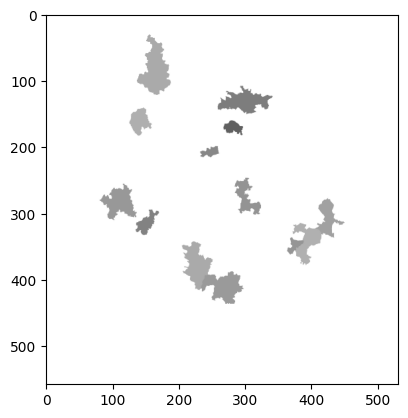

time: 160 ms (started: 2023-03-15 19:03:44 +05:30)


In [17]:
path = '../../../../dataset/aqi/images/2017-01.png'
img = Image.open(path)
img = img.convert('RGB')
plt.imshow(img);

In [18]:
img = img.crop(scaling['bbox'])
img.size

(472, 496)

time: 12.9 ms (started: 2023-03-15 19:03:44 +05:30)


In [19]:
img = np.asarray(img)
img.shape

(496, 472, 3)

time: 4.12 ms (started: 2023-03-15 19:03:44 +05:30)


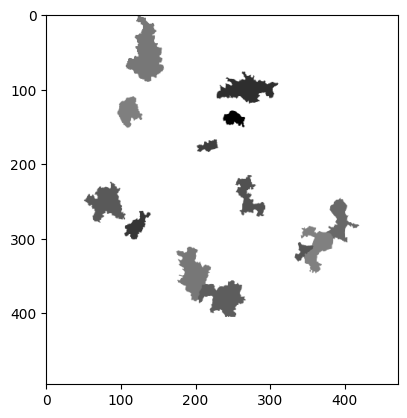

time: 124 ms (started: 2023-03-15 19:03:44 +05:30)


In [20]:
plt.imshow(img[:, :, 0], cmap='gray');

In [21]:
tmp = img[:, :, 0]
tmp.shape

(496, 472)

time: 1.43 ms (started: 2023-03-15 19:03:44 +05:30)


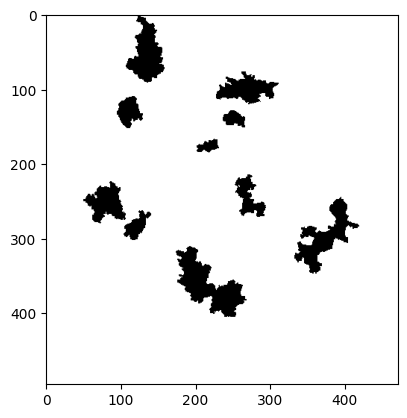

time: 97.5 ms (started: 2023-03-15 19:03:44 +05:30)


In [22]:
plt.imshow(np.array(tmp == 255).astype(np.uint8), cmap='gray');

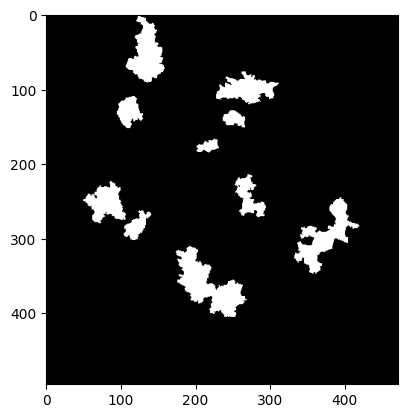

time: 105 ms (started: 2023-03-15 19:03:44 +05:30)


In [23]:
mask = (tmp == 255)
mask = ~mask.astype(np.uint8) - 254
plt.imshow(mask, cmap='gray');

In [24]:
mask.min(), mask.max()

(0, 1)

time: 2.83 ms (started: 2023-03-15 19:03:44 +05:30)


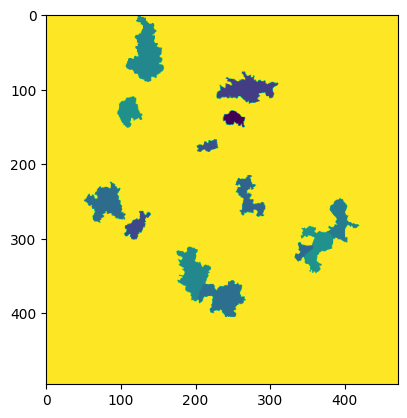

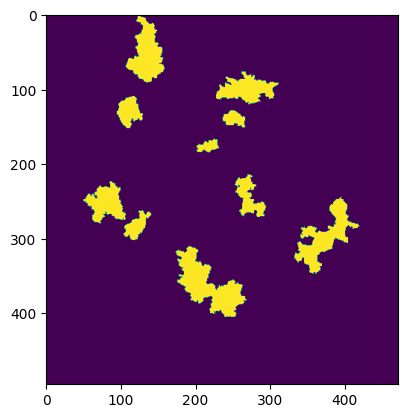

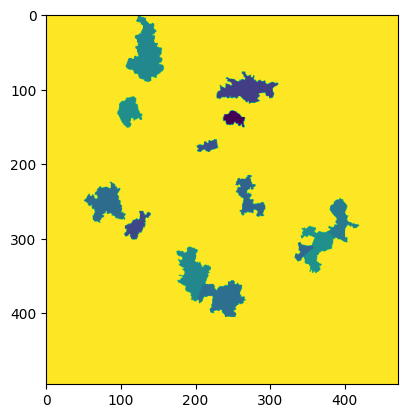

time: 242 ms (started: 2023-03-15 19:03:44 +05:30)


In [25]:
plt.imshow(mask + tmp)
plt.show()

plt.imshow(mask)
plt.show()

plt.imshow(tmp)
plt.show()

In [26]:
image_paths = sorted(glob('../../../../dataset/aqi/images/*.png'))
df = pd.DataFrame({
    'input': image_paths
})
df.head()

,input
0,../../../../dataset/aqi/images/2017-01.png
1,../../../../dataset/aqi/images/2017-02.png
2,../../../../dataset/aqi/images/2017-03.png
3,../../../../dataset/aqi/images/2017-04.png
4,../../../../dataset/aqi/images/2017-05.png


time: 8.04 ms (started: 2023-03-15 19:03:44 +05:30)


In [27]:
df.shape

(60, 1)

time: 2.27 ms (started: 2023-03-15 19:03:44 +05:30)


In [28]:
df['output'] = np.nan
for ix in range(4, len(df) - 1):
    df.loc[ix - 1, 'output'] = df.loc[ix, 'input']
df.head()

,input,output
0,../../../../dataset/aqi/images/2017-01.png,NaN
1,../../../../dataset/aqi/images/2017-02.png,NaN
2,../../../../dataset/aqi/images/2017-03.png,NaN
3,../../../../dataset/aqi/images/2017-04.png,../../../../dataset/aqi/images/2017-05.png
4,../../../../dataset/aqi/images/2017-05.png,../../../../dataset/aqi/images/2017-06.png


time: 10.3 ms (started: 2023-03-15 19:03:44 +05:30)


In [29]:
input_paths:  List[List[str]] = []
output_paths: List[str] = []

for ix in range(2, len(df) - 1):
    input_paths.append(df.loc[ix - 2: ix, 'input'].to_list())
    output_paths.append(df.loc[ix, 'output'])

for inp, out in zip(input_paths, output_paths):
    print(inp, out)
    break

['../../../../dataset/aqi/images/2017-01.png', '../../../../dataset/aqi/images/2017-02.png', '../../../../dataset/aqi/images/2017-03.png'] nan
time: 4.46 ms (started: 2023-03-15 19:03:44 +05:30)


In [30]:
class AQIDataset(Dataset):
    def __init__(self, input_paths: List[str], output_paths: List[str]) -> None:
        super(AQIDataset, self).__init__()
        self.input_paths = input_paths
        self.output_paths = output_paths
        self.transforms = A.Compose([
            A.Resize(height=config.image_size[0], width=config.image_size[1]),
            ToTensorV2()
        ], p=1.0)
        
    def __len__(self) -> int:
        return len(self.input_paths)
    
    def __getitem__(self, ix: int) -> Dict[str, torch.Tensor]:
        input_paths = self.input_paths[ix]
        output_path = self.output_paths[ix]
        
        X = None
        masks = None
        y = None
        
        for path in input_paths:
            img = Image.open(path)
            img = img.convert('RGB')
            img = np.asarray(img).mean(-1)
            
            transformed = self.transforms(image=img)
            image = transformed['image']
            image = torch.tensor(image)
            
            # print(image.shape)
            
            if X is None:
                X = image.unsqueeze(0)
            else:
                X = torch.cat([X, image.unsqueeze(0)], dim=1)
                
        X = X / 255
        
        img = Image.open(path)
        img = img.convert('RGB')
        img = np.asarray(img).mean(-1)
        mask = (img == 255)
        mask = ~mask.astype(np.uint8) - 244
        
        img = img / 255
        
        transformed = self.transforms(image=img, mask=mask)
        image = transformed['image']
        mask  = transformed['mask'] - transformed['mask'].min()
        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)
        
#         image = (image - scaling['min'])/(scaling['max'] - scaling['min'])
#         X = (X - scaling['min'])/(scaling['max'] - scaling['min'])
        
        return {
            'X': X.to(dtype=torch.float32), 
            'mask': mask.to(dtype=torch.float32).unsqueeze(0), 
            'y': image.to(dtype=torch.float32)
        }

time: 1.71 ms (started: 2023-03-15 19:03:44 +05:30)


In [31]:
dataset = AQIDataset(input_paths, output_paths)

time: 1.06 ms (started: 2023-03-15 19:03:44 +05:30)


In [32]:
batch = dataset[0]
{k: v.shape for k, v in batch.items()}

{'X': torch.Size([1, 3, 224, 224]),
 'mask': torch.Size([1, 224, 224]),
 'y': torch.Size([1, 224, 224])}

time: 70.3 ms (started: 2023-03-15 19:03:44 +05:30)


In [33]:
batch['y'].min(), batch['y'].max()

(tensor(0.4902), tensor(1.))

time: 5.41 ms (started: 2023-03-15 19:03:45 +05:30)


In [34]:
len(dataset)

57

time: 2.21 ms (started: 2023-03-15 19:03:45 +05:30)


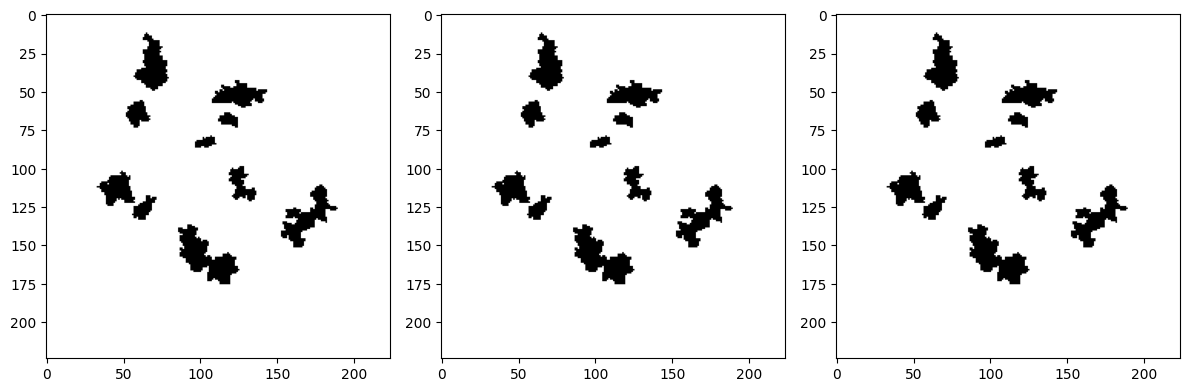

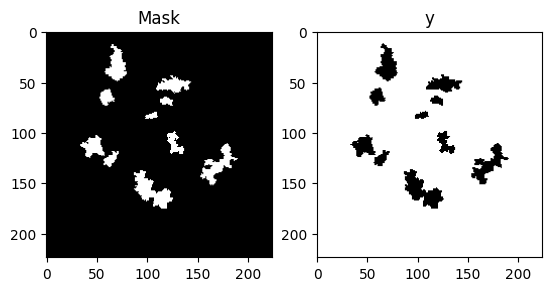

time: 458 ms (started: 2023-03-15 19:03:45 +05:30)


In [35]:
fig, axs = plt.subplots(1, 3, figsize=(12, 8))
for ix, ax in enumerate(axs.flatten()):
    ax.imshow(batch['X'][0, ix, :, :].numpy().astype(np.uint8), cmap='gray')
plt.tight_layout()
plt.show()

plt.subplot(121)
plt.imshow(batch['mask'].permute(1, 2, 0).numpy().astype(np.uint8), cmap='gray')
plt.title('Mask')

plt.subplot(122)
plt.imshow(batch['y'].permute(1, 2, 0).numpy().astype(np.uint8), cmap='gray')
plt.title('y')

plt.show()

In [36]:
batch['mask'].max(), batch['mask'].min()

(tensor(1.), tensor(0.))

time: 2.67 ms (started: 2023-03-15 19:03:45 +05:30)


In [37]:
model = Pix2PixRNN(in_channels=1)
model

Pix2PixRNN(
  (encoder): EncoderLayer(
    (conv1): Conv2DLayer(
      (conv): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): Conv2DLayer(
      (conv): Conv2d(32, 16, kernel_size=(2, 2), stride=(4, 4), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): Conv2DLayer(
      (conv): Conv2d(16, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (fc): Linear(in_features=225, out_features=128, bias=True)
  )
  (lstm): LSTM(128, 512, num_layers=2, batch_first=True)
  (decoder): DecoderLayer(
    (conv1): Conv2DTransposeLayer(
      (conv): ConvTranspose2d(512, 128, kernel_size=(6, 6), stride=(3, 3), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_ru

time: 32.5 ms (started: 2023-03-15 19:03:45 +05:30)


In [38]:
loader = DataLoader(dataset, batch_size=4)

time: 303 µs (started: 2023-03-15 19:03:45 +05:30)


In [39]:
batch = next(iter(loader))
{k: v.shape for k, v in batch.items()}

{'X': torch.Size([4, 1, 3, 224, 224]),
 'mask': torch.Size([4, 1, 224, 224]),
 'y': torch.Size([4, 1, 224, 224])}

time: 226 ms (started: 2023-03-15 19:03:45 +05:30)


In [40]:
y = model.forward(batch['X'])
y.shape

torch.Size([4, 1, 224, 224])

time: 21 ms (started: 2023-03-15 19:03:45 +05:30)


In [41]:
{k: v.shape for k, v in batch.items()}

{'X': torch.Size([4, 1, 3, 224, 224]),
 'mask': torch.Size([4, 1, 224, 224]),
 'y': torch.Size([4, 1, 224, 224])}

time: 1.71 ms (started: 2023-03-15 19:03:45 +05:30)


Predicted:-


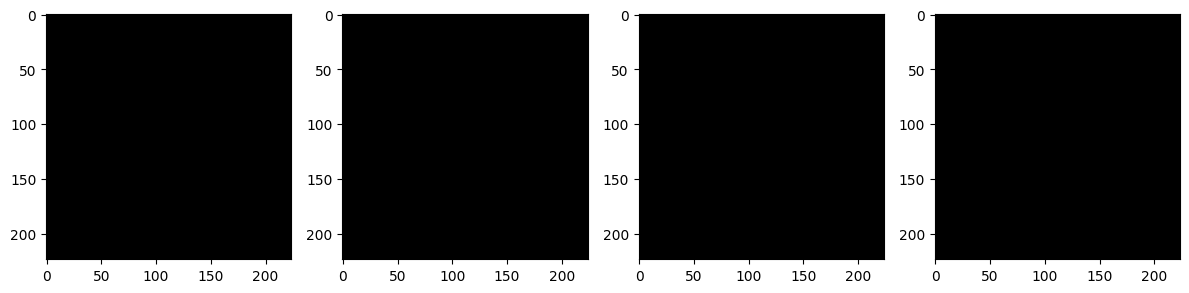

Masks:-


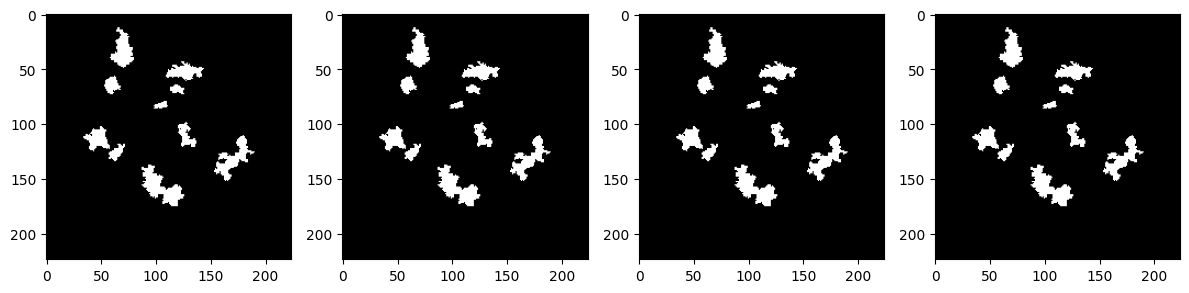

Actual:-


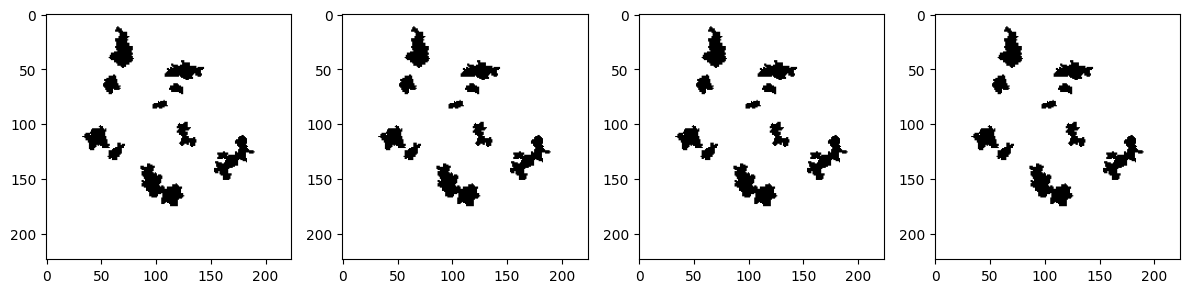

time: 682 ms (started: 2023-03-15 19:03:45 +05:30)


In [42]:
print('Predicted:-')
fig, axs = plt.subplots(1, 4, figsize=(12, 8))
for ix, ax in enumerate(axs.flatten()):
    ax.imshow(y[ix, ...].detach().permute(1, 2, 0).numpy().astype(np.uint8), cmap='gray')
plt.tight_layout()
plt.show()

print('Masks:-')
fig, axs = plt.subplots(1, 4, figsize=(12, 8))
for ix, ax in enumerate(axs.flatten()):
    ax.imshow(batch['mask'][ix].permute(1, 2, 0).numpy().astype(np.uint8), cmap='gray')
plt.tight_layout()
plt.show()

print('Actual:-')
fig, axs = plt.subplots(1, 4, figsize=(12, 8))
for ix, ax in enumerate(axs.flatten()):
    ax.imshow(batch['y'][ix].permute(1, 2, 0).numpy().astype(np.uint8), cmap='gray')
plt.tight_layout()
plt.show()

In [43]:
batch['mask'].max(), batch['mask'].min()

(tensor(1.), tensor(0.))

time: 2.56 ms (started: 2023-03-15 19:03:46 +05:30)


In [44]:
len(input_paths), len(output_paths)

(57, 57)

time: 1.22 ms (started: 2023-03-15 19:03:46 +05:30)


In [45]:
train_paths = {
    'input': input_paths[:48], 
    'output': output_paths[:48]
}

valid_paths = {
    'input': input_paths[48: ],
    'output': output_paths[48: ]
}

{k: len(v) for k, v in train_paths.items()}

{'input': 48, 'output': 48}

time: 1.97 ms (started: 2023-03-15 19:03:46 +05:30)


In [46]:
{k: len(v) for k, v in valid_paths.items()}

{'input': 9, 'output': 9}

time: 2.6 ms (started: 2023-03-15 19:03:46 +05:30)


In [47]:
train_dataset = AQIDataset(input_paths=train_paths['input'], output_paths=train_paths['output'])
valid_dataset = AQIDataset(input_paths=valid_paths['input'], output_paths=valid_paths['output'])

train_loader = DataLoader(dataset=train_dataset, batch_size=config.train_bs)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=config.valid_bs)

time: 485 µs (started: 2023-03-15 19:03:46 +05:30)


In [48]:
batch = next(iter(train_loader))
{k: v.shape for k, v in batch.items()}, len(train_loader)

({'X': torch.Size([1, 1, 3, 224, 224]),
  'mask': torch.Size([1, 1, 224, 224]),
  'y': torch.Size([1, 1, 224, 224])},
 48)

time: 67.4 ms (started: 2023-03-15 19:03:46 +05:30)


In [49]:
batch = next(iter(valid_loader))
{k: v.shape for k, v in batch.items()}, len(valid_loader)

({'X': torch.Size([1, 1, 3, 224, 224]),
  'mask': torch.Size([1, 1, 224, 224]),
  'y': torch.Size([1, 1, 224, 224])},
 9)

time: 60.6 ms (started: 2023-03-15 19:03:46 +05:30)


In [50]:
model = Pix2PixRNN(in_channels=1)
model

Pix2PixRNN(
  (encoder): EncoderLayer(
    (conv1): Conv2DLayer(
      (conv): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): Conv2DLayer(
      (conv): Conv2d(32, 16, kernel_size=(2, 2), stride=(4, 4), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): Conv2DLayer(
      (conv): Conv2d(16, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (fc): Linear(in_features=225, out_features=128, bias=True)
  )
  (lstm): LSTM(128, 512, num_layers=2, batch_first=True)
  (decoder): DecoderLayer(
    (conv1): Conv2DTransposeLayer(
      (conv): ConvTranspose2d(512, 128, kernel_size=(6, 6), stride=(3, 3), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_ru

time: 31.6 ms (started: 2023-03-15 19:03:46 +05:30)


In [51]:
if os.path.exists('../../best-models/'):
    pass
else:
    os.mkdir('../../best-models/')

time: 325 µs (started: 2023-03-15 19:03:46 +05:30)


In [52]:
model, history = run_training(trainloader=train_loader, validloader=valid_loader)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


					### EPOCH 1 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:21<00:00,  2.44s/it]


Validation Loss: 0.00151
Validation decreased from inf to 0.00151
Model Saved
					### EPOCH 2 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.58it/s]


Validation Loss: 0.00104
Validation decreased from 0.00151 to 0.00104
Model Saved
					### EPOCH 3 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.67it/s]


Validation Loss: 0.00096
Validation decreased from 0.00104 to 0.00096
Model Saved
					### EPOCH 4 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.82it/s]


Validation Loss: 0.00092
Validation decreased from 0.00096 to 0.00092
Model Saved
					### EPOCH 5 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.05it/s]


Validation Loss: 0.00091
Validation decreased from 0.00092 to 0.00091
Model Saved
					### EPOCH 6 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.17it/s]


Validation Loss: 0.00091
Validation decreased from 0.00091 to 0.00091
Model Saved
					### EPOCH 7 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.68it/s]


Validation Loss: 0.00088
Validation decreased from 0.00091 to 0.00088
Model Saved
					### EPOCH 8 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.03it/s]


Validation Loss: 0.00087
Validation decreased from 0.00088 to 0.00087
Model Saved
					### EPOCH 9 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  6.88it/s]


Validation Loss: 0.00085
Validation decreased from 0.00087 to 0.00085
Model Saved
					### EPOCH 10 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.18it/s]


Validation Loss: 0.00085
Validation decreased from 0.00085 to 0.00085
Model Saved
					### EPOCH 11 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.06it/s]


Validation Loss: 0.00083
Validation decreased from 0.00085 to 0.00083
Model Saved
					### EPOCH 12 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.97it/s]


Validation Loss: 0.00085
					### EPOCH 13 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.10it/s]


Validation Loss: 0.00079
Validation decreased from 0.00083 to 0.00079
Model Saved
					### EPOCH 14 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.92it/s]


Validation Loss: 0.00078
Validation decreased from 0.00079 to 0.00078
Model Saved
					### EPOCH 15 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.75it/s]


Validation Loss: 0.00077
Validation decreased from 0.00078 to 0.00077
Model Saved
					### EPOCH 16 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.09it/s]


Validation Loss: 0.00076
Validation decreased from 0.00077 to 0.00076
Model Saved
					### EPOCH 17 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.63it/s]


Validation Loss: 0.00075
Validation decreased from 0.00076 to 0.00075
Model Saved
					### EPOCH 18 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.15it/s]


Validation Loss: 0.00075
Validation decreased from 0.00075 to 0.00075
Model Saved
					### EPOCH 19 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.04it/s]


Validation Loss: 0.00075
					### EPOCH 20 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.10it/s]


Validation Loss: 0.00075
Validation decreased from 0.00075 to 0.00075
Model Saved
					### EPOCH 21 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.46it/s]


Validation Loss: 0.00077
					### EPOCH 22 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.17it/s]


Validation Loss: 0.00074
Validation decreased from 0.00075 to 0.00074
Model Saved
					### EPOCH 23 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.10it/s]


Validation Loss: 0.00075
					### EPOCH 24 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.00it/s]


Validation Loss: 0.00074
Validation decreased from 0.00074 to 0.00074
Model Saved
					### EPOCH 25 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.95it/s]


Validation Loss: 0.00083
					### EPOCH 26 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.08it/s]


Validation Loss: 0.00073
Validation decreased from 0.00074 to 0.00073
Model Saved
					### EPOCH 27 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.99it/s]


Validation Loss: 0.00071
Validation decreased from 0.00073 to 0.00071
Model Saved
					### EPOCH 28 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.20it/s]


Validation Loss: 0.00126
					### EPOCH 29 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.84it/s]


Validation Loss: 0.00069
Validation decreased from 0.00071 to 0.00069
Model Saved
					### EPOCH 30 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.74it/s]


Validation Loss: 0.00069
Validation decreased from 0.00069 to 0.00069
Model Saved
					### EPOCH 31 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.05it/s]


Validation Loss: 0.00067
Validation decreased from 0.00069 to 0.00067
Model Saved
					### EPOCH 32 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.06it/s]


Validation Loss: 0.00067
Validation decreased from 0.00067 to 0.00067
Model Saved
					### EPOCH 33 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.26it/s]


Validation Loss: 0.00065
Validation decreased from 0.00067 to 0.00065
Model Saved
					### EPOCH 34 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.12it/s]


Validation Loss: 0.00064
Validation decreased from 0.00065 to 0.00064
Model Saved
					### EPOCH 35 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.11it/s]


Validation Loss: 0.00063
Validation decreased from 0.00064 to 0.00063
Model Saved
					### EPOCH 36 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.59it/s]


Validation Loss: 0.00068
					### EPOCH 37 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.94it/s]


Validation Loss: 0.00061
Validation decreased from 0.00063 to 0.00061
Model Saved
					### EPOCH 38 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.99it/s]


Validation Loss: 0.00070
					### EPOCH 39 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.09it/s]


Validation Loss: 0.00063
					### EPOCH 40 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.98it/s]


Validation Loss: 0.00065
					### EPOCH 41 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.85it/s]


Validation Loss: 0.00063
					### EPOCH 42 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.96it/s]


Validation Loss: 0.00061
					### EPOCH 43 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.96it/s]


Validation Loss: 0.00067
					### EPOCH 44 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.01it/s]


Validation Loss: 0.00065
					### EPOCH 45 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.07it/s]


Validation Loss: 0.00062
					### EPOCH 46 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.09it/s]


Validation Loss: 0.00063
					### EPOCH 47 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.86it/s]


Validation Loss: 0.00061
					### EPOCH 48 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.69it/s]


Validation Loss: 0.00060
Validation decreased from 0.00061 to 0.00060
Model Saved
					### EPOCH 49 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.75it/s]


Validation Loss: 0.00060
Validation decreased from 0.00060 to 0.00060
Model Saved
					### EPOCH 50 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.64it/s]


Validation Loss: 0.00060
					### EPOCH 51 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.99it/s]


Validation Loss: 0.00058
Validation decreased from 0.00060 to 0.00058
Model Saved
					### EPOCH 52 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.75it/s]


Validation Loss: 0.00058
					### EPOCH 53 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.06it/s]


Validation Loss: 0.00060
					### EPOCH 54 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.08it/s]


Validation Loss: 0.00057
Validation decreased from 0.00058 to 0.00057
Model Saved
					### EPOCH 55 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.86it/s]


Validation Loss: 0.00058
					### EPOCH 56 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.93it/s]


Validation Loss: 0.00058
					### EPOCH 57 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.41it/s]


Validation Loss: 0.00059
					### EPOCH 58 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.75it/s]


Validation Loss: 0.00057
Validation decreased from 0.00057 to 0.00057
Model Saved
					### EPOCH 59 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.96it/s]


Validation Loss: 0.00057
					### EPOCH 60 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.98it/s]


Validation Loss: 0.00056
Validation decreased from 0.00057 to 0.00056
Model Saved
					### EPOCH 61 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.02it/s]


Validation Loss: 0.00056
Validation decreased from 0.00056 to 0.00056
Model Saved
					### EPOCH 62 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.77it/s]


Validation Loss: 0.00054
Validation decreased from 0.00056 to 0.00054
Model Saved
					### EPOCH 63 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.17it/s]


Validation Loss: 0.00054
					### EPOCH 64 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.71it/s]


Validation Loss: 0.00055
					### EPOCH 65 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.01it/s]


Validation Loss: 0.00054
					### EPOCH 66 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.02it/s]


Validation Loss: 0.00054
Validation decreased from 0.00054 to 0.00054
Model Saved
					### EPOCH 67 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.21it/s]


Validation Loss: 0.00055
					### EPOCH 68 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.62it/s]


Validation Loss: 0.00053
Validation decreased from 0.00054 to 0.00053
Model Saved
					### EPOCH 69 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.88it/s]


Validation Loss: 0.00052
Validation decreased from 0.00053 to 0.00052
Model Saved
					### EPOCH 70 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.76it/s]


Validation Loss: 0.00055
					### EPOCH 71 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.81it/s]


Validation Loss: 0.00055
					### EPOCH 72 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.07it/s]


Validation Loss: 0.00054
					### EPOCH 73 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.84it/s]


Validation Loss: 0.00056
					### EPOCH 74 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.27it/s]


Validation Loss: 0.00054
					### EPOCH 75 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.01it/s]


Validation Loss: 0.00054
					### EPOCH 76 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.97it/s]


Validation Loss: 0.00054
					### EPOCH 77 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.73it/s]


Validation Loss: 0.00054
					### EPOCH 78 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.88it/s]


Validation Loss: 0.00051
Validation decreased from 0.00052 to 0.00051
Model Saved
					### EPOCH 79 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.14it/s]


Validation Loss: 0.00054
					### EPOCH 80 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.08it/s]


Validation Loss: 0.00054
					### EPOCH 81 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.13it/s]


Validation Loss: 0.00054
					### EPOCH 82 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.15it/s]


Validation Loss: 0.00056
					### EPOCH 83 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.82it/s]


Validation Loss: 0.00061
					### EPOCH 84 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.50it/s]


Validation Loss: 0.00054
					### EPOCH 85 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.91it/s]


Validation Loss: 0.00062
					### EPOCH 86 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.10it/s]


Validation Loss: 0.00052
					### EPOCH 87 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.94it/s]


Validation Loss: 0.00048
Validation decreased from 0.00051 to 0.00048
Model Saved
					### EPOCH 88 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.14it/s]


Validation Loss: 0.00053
					### EPOCH 89 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.75it/s]


Validation Loss: 0.00053
					### EPOCH 90 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.73it/s]


Validation Loss: 0.00052
					### EPOCH 91 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.00it/s]


Validation Loss: 0.00054
					### EPOCH 92 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.12it/s]


Validation Loss: 0.00050
					### EPOCH 93 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.86it/s]


Validation Loss: 0.00052
					### EPOCH 94 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.12it/s]


Validation Loss: 0.00053
					### EPOCH 95 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.17it/s]


Validation Loss: 0.00053
					### EPOCH 96 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.10it/s]


Validation Loss: 0.00051
					### EPOCH 97 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.11it/s]


Validation Loss: 0.00050
					### EPOCH 98 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.91it/s]


Validation Loss: 0.00051
					### EPOCH 99 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.89it/s]


Validation Loss: 0.00051
					### EPOCH 100 ###


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.77it/s]


Validation Loss: 0.00052
time: 10min 21s (started: 2023-03-15 19:03:46 +05:30)


In [236]:
batch = next(iter(loader))
{k: v.shape for k, v in batch.items()}

{'X': torch.Size([4, 1, 3, 224, 224]),
 'mask': torch.Size([4, 1, 224, 224]),
 'y': torch.Size([4, 1, 224, 224])}

time: 269 ms (started: 2023-03-15 20:15:40 +05:30)


In [237]:
model.load_state_dict(torch.load('../../best-models/MODEL-1.bin'))

<All keys matched successfully>

time: 19.3 ms (started: 2023-03-15 20:15:41 +05:30)


In [238]:
y = model.forward(batch['X'])
y.shape

torch.Size([4, 1, 224, 224])

time: 36.3 ms (started: 2023-03-15 20:15:41 +05:30)


Predicted:-


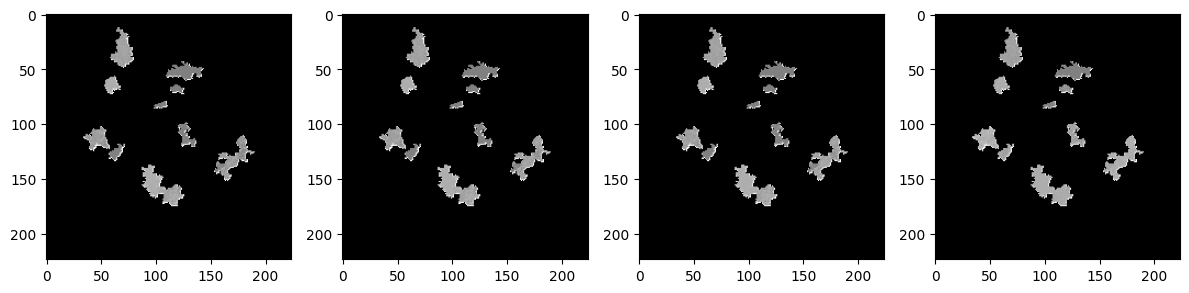

Masks:-


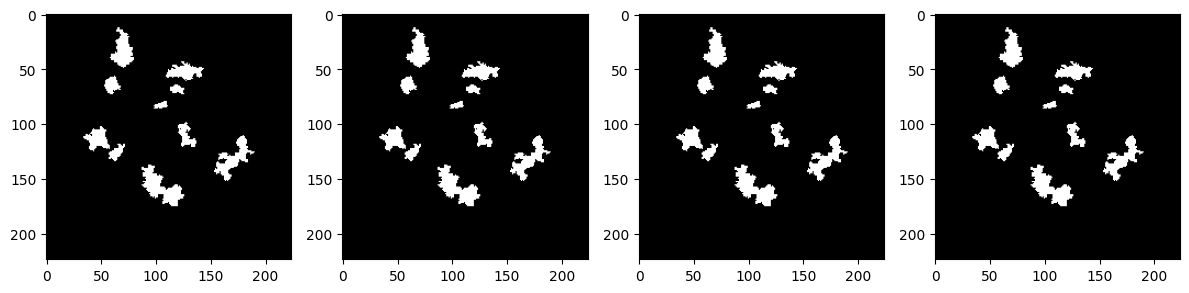

Actual:-


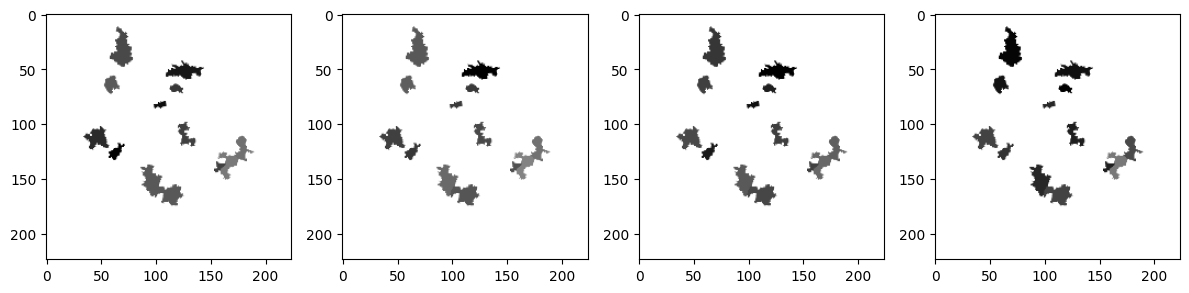

time: 891 ms (started: 2023-03-15 20:15:42 +05:30)


In [239]:
print('Predicted:-')
fig, axs = plt.subplots(1, 4, figsize=(12, 8))
for ix, ax in enumerate(axs.flatten()):
    ax.imshow((y[ix, ...] * 255 * batch['mask'][ix]).detach().permute(1, 2, 0).numpy().astype(np.uint8), cmap='gray')
plt.tight_layout()
plt.show()

print('Masks:-')
fig, axs = plt.subplots(1, 4, figsize=(12, 8))
for ix, ax in enumerate(axs.flatten()):
    ax.imshow(batch['mask'][ix].permute(1, 2, 0).numpy().astype(np.uint8), cmap='gray')
plt.tight_layout()
plt.show()

print('Actual:-')
fig, axs = plt.subplots(1, 4, figsize=(12, 8))
for ix, ax in enumerate(axs.flatten()):
    ax.imshow((batch['y'][ix] * 255).permute(1, 2, 0).numpy().astype(np.uint8), cmap='gray')
plt.tight_layout()
plt.show()

# Future Predictions

Predicted:-


IndexError: index 1 is out of bounds for dimension 0 with size 1

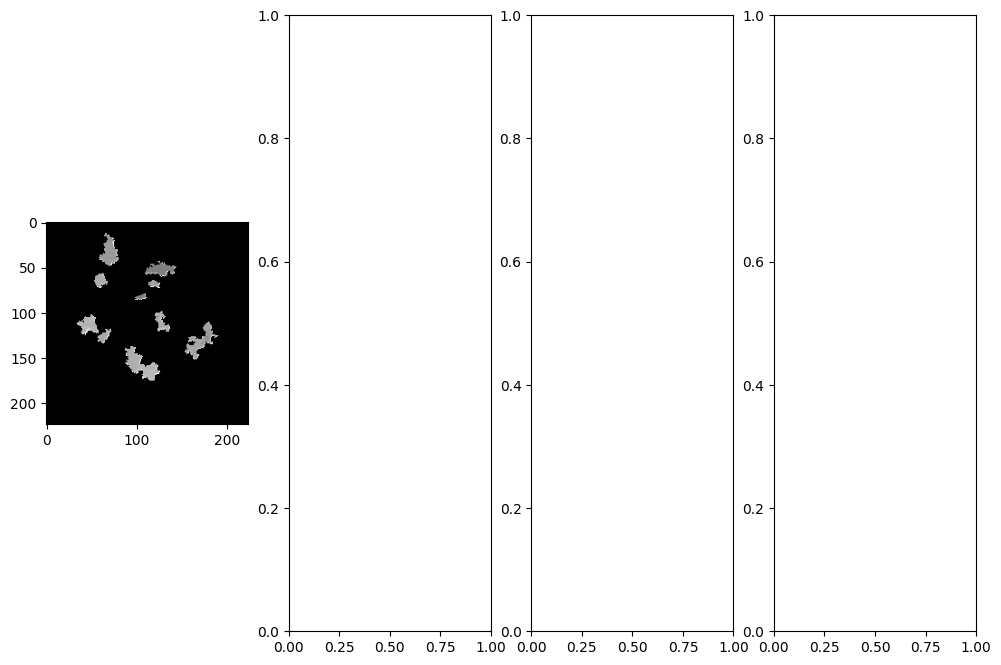

time: 386 ms (started: 2023-03-15 20:24:57 +05:30)


In [281]:
print('Predicted:-')
fig, axs = plt.subplots(1, 4, figsize=(12, 8))
for ix, ax in enumerate(axs.flatten()):
    ax.imshow((y[ix, ...] * 255 * batch['mask'][ix]).detach().permute(1, 2, 0).numpy().astype(np.uint8), cmap='gray')
plt.tight_layout()
plt.show()

In [ ]:
print('Masks:-')
fig, axs = plt.subplots(1, 4, figsize=(12, 8))
for ix, ax in enumerate(axs.flatten()):
    ax.imshow(~batch['mask'][ix].permute(1, 2, 0).numpy().astype(np.uint8), cmap='gray')
plt.tight_layout()
plt.show()

In [ ]:
batch['mask'].min(), batch['mask'].max()

Masks:-


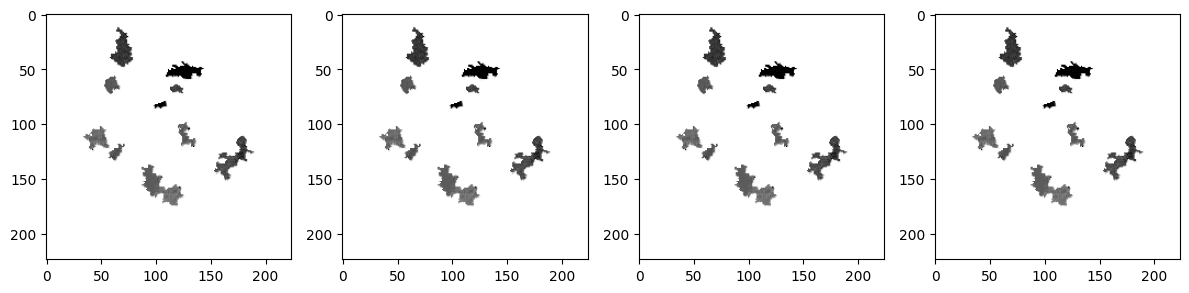

time: 325 ms (started: 2023-03-15 20:24:57 +05:30)


In [282]:
z = y * (~batch['mask'].to(torch.bool))
z = torch.where(batch['mask'] == 0., 255, y * 255)
print('Masks:-')
fig, axs = plt.subplots(1, 4, figsize=(12, 8))
for ix, ax in enumerate(axs.flatten()):
    ax.imshow((z[ix, ...] * 255).detach().permute(1, 2, 0), cmap='gray')
plt.tight_layout()
plt.show()

In [283]:
z.min(), z.max()

(tensor(127.5000, grad_fn=<MinBackward1>),
 tensor(255., grad_fn=<MaxBackward1>))

time: 3.02 ms (started: 2023-03-15 20:24:58 +05:30)


In [284]:
valid_paths['input'][-1]

['../../../../dataset/aqi/images/2021-09.png',
 '../../../../dataset/aqi/images/2021-10.png',
 '../../../../dataset/aqi/images/2021-11.png']

time: 2.16 ms (started: 2023-03-15 20:24:58 +05:30)


In [285]:
input_paths = valid_paths['input'][-1]
transforms = train_dataset.transforms
X = None
for path in input_paths:
    img = Image.open(path)
    img = img.convert('RGB')
    img = np.asarray(img).mean(-1)
            
    transformed = transforms(image=img)
    image = transformed['image']
    image = torch.tensor(image)
            
    # print(image.shape)
    
    if X is None:
        X = image.unsqueeze(0)
    else:
        X = torch.cat([X, image.unsqueeze(0)], dim=1)

time: 46.8 ms (started: 2023-03-15 20:24:58 +05:30)


In [286]:
X = X.unsqueeze(0).to(dtype=torch.float32)
X.shape

torch.Size([1, 1, 3, 224, 224])

time: 5.65 ms (started: 2023-03-15 20:24:59 +05:30)


In [287]:
model.load_state_dict(torch.load('../../best-models/MODEL-1.bin'))

<All keys matched successfully>

time: 11.7 ms (started: 2023-03-15 20:24:59 +05:30)


In [288]:
yHat = model.forward(X)

time: 24.2 ms (started: 2023-03-15 20:25:00 +05:30)


In [289]:
yHat.shape

torch.Size([1, 1, 224, 224])

time: 2.62 ms (started: 2023-03-15 20:25:00 +05:30)


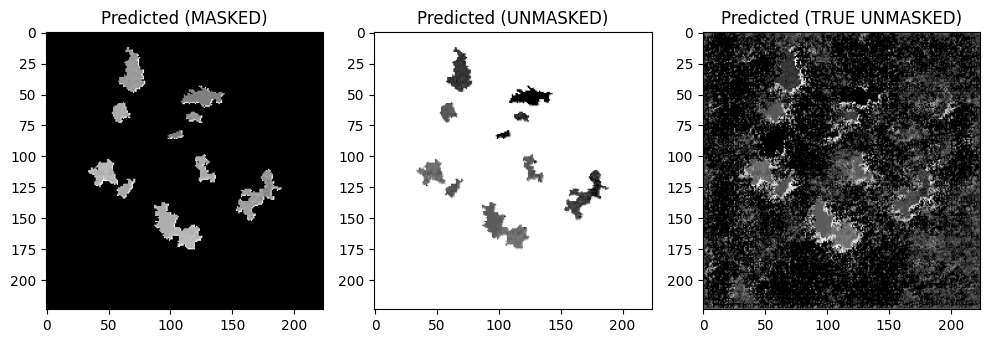

time: 334 ms (started: 2023-03-15 20:25:00 +05:30)


In [290]:
z = yHat * (~batch['mask'][0, ...].to(torch.bool))
z = torch.where(batch['mask'][0, ...] == 0., 255, yHat * 255)[0]

plt.figure(figsize=(10, 4))

plt.subplot(131)
plt.imshow((yHat[0].detach().permute(1, 2, 0).numpy()*batch['mask'][0].permute(1, 2, 0).numpy()), cmap='gray')
plt.title('Predicted (MASKED)')

plt.subplot(132)
plt.imshow(z.detach().permute(1, 2, 0).numpy(), cmap='gray')
plt.title('Predicted (UNMASKED)')

plt.subplot(133)
plt.imshow(y[0].detach().permute(1, 2, 0).numpy(), cmap='gray')
plt.title('Predicted (TRUE UNMASKED)')

plt.tight_layout()
plt.show()

In [291]:
X.shape

torch.Size([1, 1, 3, 224, 224])

time: 1.98 ms (started: 2023-03-15 20:25:01 +05:30)


In [292]:
z.shape

torch.Size([1, 224, 224])

time: 5.02 ms (started: 2023-03-15 20:25:02 +05:30)


In [293]:
t = torch.rand((1, 224, 224)).unsqueeze(0).unsqueeze(0)
X.shape

torch.Size([1, 1, 3, 224, 224])

time: 3.13 ms (started: 2023-03-15 20:25:02 +05:30)


In [294]:
t.shape

torch.Size([1, 1, 1, 224, 224])

time: 2.8 ms (started: 2023-03-15 20:25:02 +05:30)


In [295]:
torch.cat([X, t], axis=2).shape

torch.Size([1, 1, 4, 224, 224])

time: 2.58 ms (started: 2023-03-15 20:25:03 +05:30)


torch.Size([1, 224, 224]) torch.Size([1, 1, 3, 224, 224])


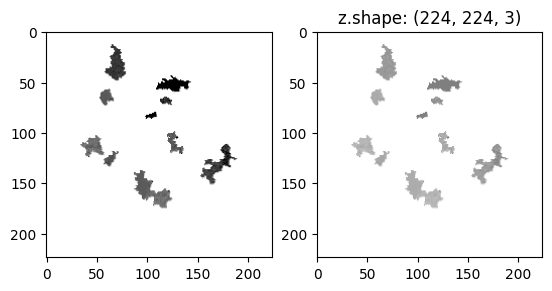

torch.Size([1, 224, 224]) torch.Size([1, 1, 3, 224, 224])


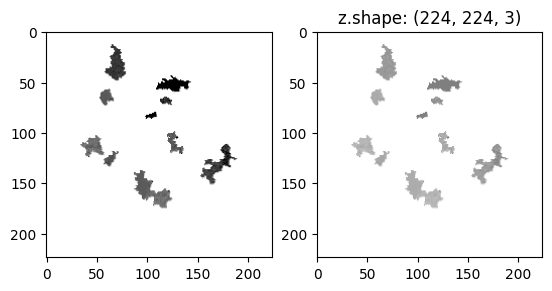

torch.Size([1, 224, 224]) torch.Size([1, 1, 3, 224, 224])


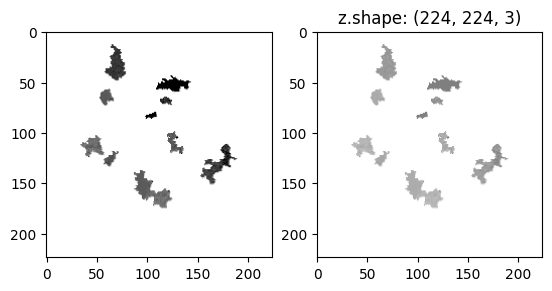

torch.Size([1, 224, 224]) torch.Size([1, 1, 3, 224, 224])


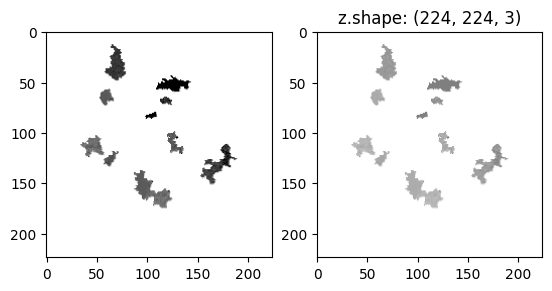

torch.Size([1, 224, 224]) torch.Size([1, 1, 3, 224, 224])


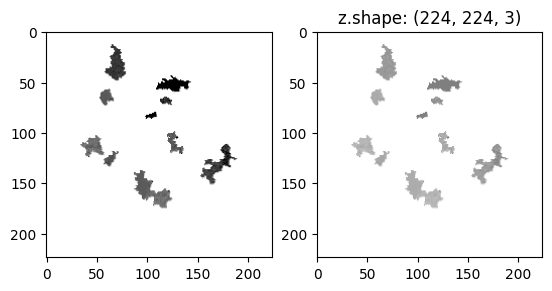

torch.Size([1, 224, 224]) torch.Size([1, 1, 3, 224, 224])


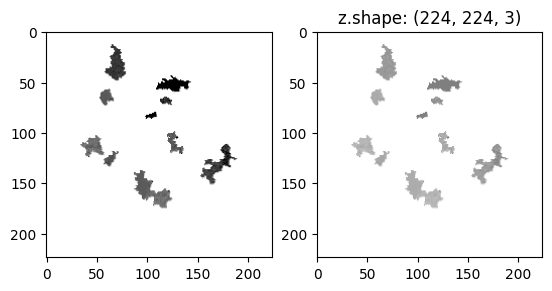

torch.Size([1, 224, 224]) torch.Size([1, 1, 3, 224, 224])


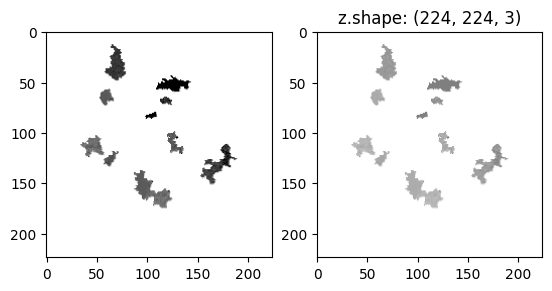

torch.Size([1, 224, 224]) torch.Size([1, 1, 3, 224, 224])


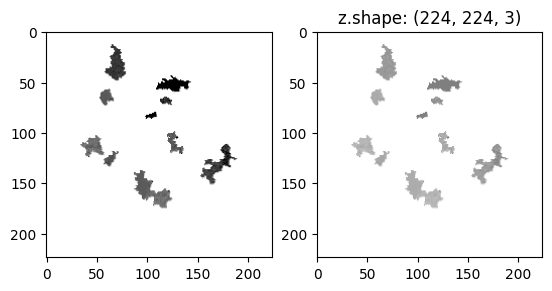

torch.Size([1, 224, 224]) torch.Size([1, 1, 3, 224, 224])


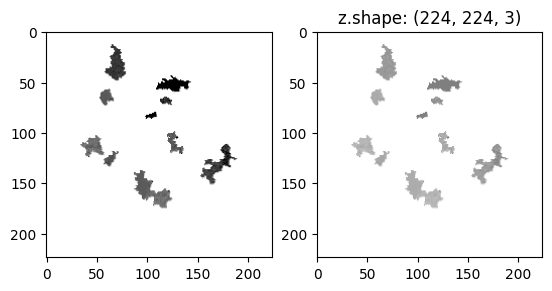

torch.Size([1, 224, 224]) torch.Size([1, 1, 3, 224, 224])


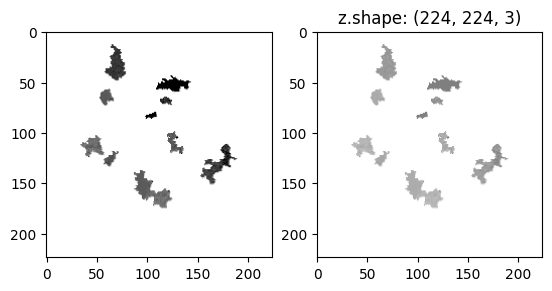

torch.Size([1, 224, 224]) torch.Size([1, 1, 3, 224, 224])


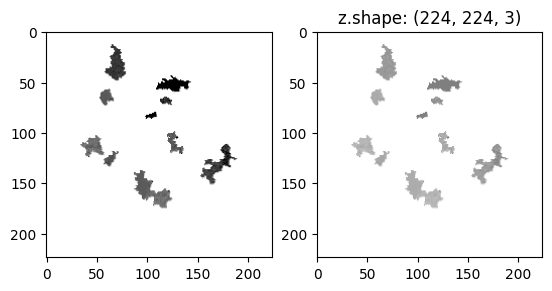

torch.Size([1, 224, 224]) torch.Size([1, 1, 3, 224, 224])


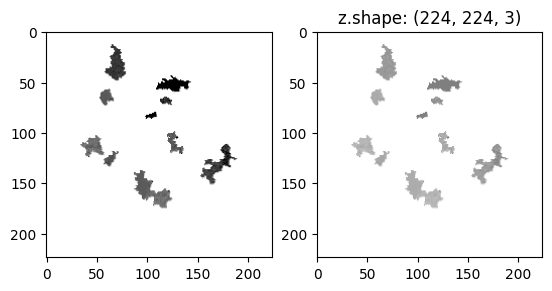

time: 2 s (started: 2023-03-15 20:25:04 +05:30)


In [296]:
model.load_state_dict(torch.load('../../best-models/MODEL-1.bin'))

for ix in range(12):
    y = model.forward(X)
    z = torch.where(batch['mask'][0, ...] == 0., 255, yHat * 255)[0]
    X = torch.cat([X, z.unsqueeze(0).unsqueeze(0)], axis=2)
    X = X[:, :, 1:, ...]
    print(z.shape, X.shape)
    z = z.detach().permute(1, 2, 0).numpy()
    plt.subplot(121)
    plt.imshow(z, cmap='gray')
    
    plt.subplot(122)
    z = np.repeat(z, 3, axis=-1).astype(np.uint8)
    plt.imshow(z, cmap='gray')
    plt.title(f'z.shape: {z.shape}')
    
    plt.show()
    plt.imsave(f'../../outputs/aqi/aqi_{ix+1}.png', z, cmap='gray')
    
    # X = torch.cat([])

In [280]:
z.shape

(224, 224, 3)

time: 6.26 ms (started: 2023-03-15 20:22:09 +05:30)
